# Stability

## Import

In [312]:
import sys
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from scipy.stats import logistic
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm 
from ast import literal_eval
from scipy.spatial.distance import cosine
from scipy.stats.stats import pearsonr, spearmanr   
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.autograd import Variable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

## Configs

In [313]:
EXPERIMENTS = ['HRCE-1', 'HRCE-2']
PLATE_NUMBERS = {
    'HRCE-1': 26,
    'HRCE-2': 27
}

## Data Paths

In [17]:
DATA_PATH = '../../data'
FEATURES_PATH = os.path.join('../..', 'features')
CP_NORMAL_FILE = 'normalized_well_profile.csv'
METADATA_PATH = os.path.join(DATA_PATH, 'metadata.csv')
WELL_CELL_COUNTS_PATH = os.path.join(DATA_PATH, 'significant_replicates', 'cell_count.csv')

## Load and Prepare Dataset

In [4]:
def load_profiles(experiments, plate_numbers, profile_name, drop_cols=[]):
    profiles = []
    for experiment in experiments:
        for i in tqdm(range(1, plate_numbers[experiment]+1)):
            data_path = os.path.join(
                FEATURES_PATH, experiment, 'Plate'+str(i), profile_name)
            profile = pd.read_csv(data_path)
            if 'well_id' not in profile.columns: print(i)
            profiles.append(profile)
    profiles = (
        pd.concat(profiles, axis=0, join='inner').drop(drop_cols, axis=1)
    ).dropna(axis=1)
    granularity_columns = [x for x in profiles.columns if ('Granularity' in x)]
    profiles = profiles.drop(granularity_columns, axis=1)
    return profiles

In [5]:
profiles = load_profiles(EXPERIMENTS, PLATE_NUMBERS, CP_NORMAL_FILE, drop_cols=['label', 'groupid'])
profiles.shape

100%|███████████████████████████████████████████| 27/27 [00:26<00:00,  1.02it/s]


(71013, 2329)

In [6]:
def load_metadata(metadata_path, experiments):
    def label(disease_condition):
        if  disease_condition == 0: return 'negctrl'
        else: return 'posctrl'
    metadata = pd.read_csv(metadata_path)    
    metadata = metadata[metadata.experiment.isin(experiments)]
    metadata.treatment = metadata.treatment.str.lower()
    metadata = metadata[['treatment', 'treatment_conc' , 'well_id', 'disease_condition']]
    metadata = metadata.fillna(0)
    metadata['label'] = metadata.apply(lambda row: label(row.disease_condition), axis=1)
    metadata = metadata.assign(
        groupid = metadata.groupby(
            ['treatment', 'treatment_conc', 'disease_condition']).ngroup())
    metadata = metadata.assign(
        treatmentid = metadata.groupby(
            ['treatment', 'disease_condition']).ngroup())
    return metadata

In [7]:
metadata = load_metadata(METADATA_PATH, EXPERIMENTS).set_index('well_id')

In [8]:
def add_metadata_to_profiles(metadata, profiles):
    return (
        metadata.join(profiles.set_index('well_id'), how='inner')
        .drop_duplicates()
    )

In [9]:
profiles_with_meta = add_metadata_to_profiles(metadata, profiles)
profiles_with_meta.shape

(71013, 2334)

In [18]:
well_cell_counts = pd.read_csv(WELL_CELL_COUNTS_PATH)
toxic_wells = well_cell_counts[well_cell_counts.cell_count < 75].well_id.unique()
len(toxic_wells)

2677

In [19]:
toxics = (
    profiles_with_meta[profiles_with_meta.index.isin(toxic_wells)]
    .drop(metadata.columns, axis=1)
)

non_toxics = profiles_with_meta[~profiles_with_meta.index.isin(toxic_wells)]


ctrls = (
    non_toxics[non_toxics.label == 'negctrl']
    .drop(metadata.columns, axis=1)
)

active_sars = (
    non_toxics[
        (non_toxics.disease_condition == 'Active SARS-CoV-2') &
        (non_toxics.treatment == 0)
    ]
).drop(metadata.columns, axis=1)

mocks  = (
    non_toxics[non_toxics.disease_condition == 'Mock']
    .drop(metadata.columns, axis=1)
)

UV_inactive_sars = (
    non_toxics[
    non_toxics.disease_condition == 'UV Inactivated SARS-CoV-2']
    .drop(metadata.columns, axis=1)
)

treatments = (
    profiles_with_meta[profiles_with_meta.treatment != 0]
    .drop(metadata.columns, axis=1)
)

features = profiles.set_index('well_id')

treatments.shape, active_sars.shape, mocks.shape, UV_inactive_sars.shape, ctrls.shape, features.shape

((61693, 2328),
 (3377, 2328),
 (2107, 2328),
 (2108, 2328),
 (1172, 2328),
 (71013, 2328))

## PCA Whitening

In [20]:
pca = PCA(n_components=1024, whiten=True).fit(ctrls)

In [21]:
tvn_treatments = pd.DataFrame(pca.transform(treatments), index=treatments.index)
tvn_actives = pd.DataFrame(pca.transform(active_sars), index=active_sars.index)
tvn_mocks = pd.DataFrame(pca.transform(mocks), index=mocks.index)
tvn_uvs = pd.DataFrame(pca.transform(UV_inactive_sars), index=UV_inactive_sars.index)
tvn_ctrls = pd.DataFrame(pca.transform(ctrls), index=ctrls.index)
tvn_toxics = pd.DataFrame(pca.transform(toxics), index=toxics.index)

tvn_features = pd.concat(
    [tvn_treatments, tvn_actives, tvn_mocks, tvn_uvs, tvn_ctrls, tvn_toxics], axis=0
)
tvn_features.shape

(73127, 1024)

## on-off disease score

In [32]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def calculate_on_score(sample, origin, axis):
    sample_vector = np.array(sample) - np.array(origin)
    axis_vector = np.array(axis) - np.array(origin)

    result = np.dot(sample_vector, unit_vector(axis_vector).T)
    return result

def calculate_off_score(sample, origin, axis):
    sample_vector = np.array(sample) - np.array(origin)
    axis_vector = np.array(axis) - np.array(origin)
    axis_image = np.dot(sample_vector, unit_vector(axis_vector).T)
    result = np.linalg.norm(sample_vector - unit_vector(axis_vector)*axis_image)
    return result

In [30]:
def calculate_on_off_scores(tvn_ctrls, tvn_actives, tvn_features):
    zero_center = tvn_ctrls.mean()
    one_center = tvn_actives.mean()

    cpe_scores = tvn_features.apply(
        lambda row: 
        pd.Series({
            'on_score':calculate_on_score(row.values, zero_center, one_center), 
            'off_score':calculate_off_score(row.values, zero_center, one_center)
        }), axis=1)
    cpe_scores['sigmoid_on_score'] = cpe_scores.on_score.apply(lambda x: logistic.cdf(x))
    return cpe_scores

In [24]:
def gram_schmit(v, u):
    scale = np.dot(v, u.T)/np.dot(u, u.T)
    v_prime = v - u*scale
    return v_prime

def generate_random_noise(mean, std):
    noise = []
    for i in range(len(mean)):
        noise.append(np.random.normal(mean[i],std[i]))
    return pd.Series(noise).values

def get_dataset(pca, positive_features, negative_features, augment_size=0, mean=None, std=None):
    positive_labels = np.ones(len(positive_features))
    negative_labels = np.zeros(len(negative_features))

    augmented_features = []
    aug_labels = []
    pos_mean = positive_features.mean()
    neg_mean = negative_features.mean()
    
    for i in range(augment_size):
        alpha = random.random()
        
        neg = negative_features.sample().mean().values
        pos = positive_features.sample().mean().values 
        aug_feature = alpha*pos + (1-alpha)*neg
        
#         if random.random() > 0.5:
        beta = random.random()
        noise = generate_random_noise(mean, std)
        orthogonal_noise = gram_schmit(noise, pos_mean-neg_mean)
        if np.any(np.isnan(orthogonal_noise)):
            aug_feature += (orthogonal_noise*beta)
            
        augmented_features.append(aug_feature)
        aug_labels.append(alpha)
        
    x = pd.concat([positive_features, negative_features, 
        pd.DataFrame(augmented_features, columns=positive_features.columns)], axis=0)
    y = np.concatenate([positive_labels, negative_labels, aug_labels])
    return pca.transform(x), y

def get_weakly_trainloader(mocks, ctrls, active_sars, toxics, profiles):
    dist_std = profiles.set_index('well_id').std()
    dist_mean = profiles.set_index('well_id').mean()
    
    neg_controls_features = pd.concat([mocks, ctrls], axis=0)
    pos_controls_features = pd.concat([active_sars, toxics], axis=0)
    train_x, train_y = get_dataset(
        pca, pos_controls_features, neg_controls_features, 
        augment_size=5000, mean=dist_mean, std=dist_std)

    traindataset = TensorDataset(
        torch.tensor(train_x).float(),
        torch.from_numpy(train_y).float()
    )
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=64, shuffle=True, num_workers=1)
    return trainloader

In [25]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(1024, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1), 
        )

    def forward(self, x):
        return self.layers(x)

def loss_function(output, alpha):
    output = torch.sigmoid(output)
    loss = nn.MSELoss()
    w_loss = loss(output.reshape(-1), alpha.reshape(-1))
    return w_loss

def cuda(tensor, uses_cuda):
    return tensor.cuda() if uses_cuda else tensor

def evaluate(model, valloader, use_cuda):  
    model.eval()
    test_loss = 0
    for _, data in enumerate(valloader, 0):
        inputs, targets = data

        inputs = Variable(cuda(inputs, use_cuda))
        targets = Variable(cuda(targets, use_cuda))

        outputs = mlp(inputs)
        loss = loss_function(outputs, targets)
        test_loss += loss
    model.train()
    return  test_loss/len(valloader)

def train(trainloader):
    use_cuda = torch.cuda.is_available()
    history = []
    torch.manual_seed(42)
    epochs = 200
    mlp = cuda(MLP(), use_cuda)
    optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3)
    
    for epoch in range(0, epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data

            inputs = Variable(cuda(inputs, use_cuda))
            targets = Variable(cuda(targets, use_cuda))

            optimizer.zero_grad()
            outputs = mlp(inputs)

            loss = loss_function(outputs, targets)
            loss.backward()

            optimizer.step()

    print('Training process has finished.')
        
    return mlp

In [26]:
def get_disease_score(tvn_features, mlp):
    use_cuda = torch.cuda.is_available()
    disease_scores = pd.DataFrame()
    
    disease_scores['disease_score'] = tvn_features.apply(
        lambda row:
            mlp(Variable(cuda(torch.tensor([row]), use_cuda)).float()).item(), axis=1)
    disease_scores['disease_sigmoid_score'] = tvn_features.apply(
        lambda row: torch.sigmoid(
            mlp(Variable(cuda(torch.tensor([row]), use_cuda)).float())).item(), axis=1)
    return disease_scores

In [36]:
def get_class_data(profiles_with_meta, metadata):
    toxics = (
        profiles_with_meta[profiles_with_meta.index.isin(toxic_wells)]
        .drop(metadata.columns, axis=1)
    )

    non_toxics = profiles_with_meta[~profiles_with_meta.index.isin(toxic_wells)]


    ctrls = (
        non_toxics[non_toxics.label == 'negctrl']
        .drop(metadata.columns, axis=1)
    )

    active_sars = (
        non_toxics[
            (non_toxics.disease_condition == 'Active SARS-CoV-2') &
            (non_toxics.treatment == 0)
        ]
    ).drop(metadata.columns, axis=1)

    mocks  = (
        non_toxics[non_toxics.disease_condition == 'Mock']
        .drop(metadata.columns, axis=1)
    )

    UV_inactive_sars = (
        non_toxics[
        non_toxics.disease_condition == 'UV Inactivated SARS-CoV-2']
        .drop(metadata.columns, axis=1)
    )

    treatments = (
        profiles_with_meta[profiles_with_meta.treatment != 0]
        .drop(metadata.columns, axis=1)
    )

    features = profiles.set_index('well_id')

    return treatments, active_sars, mocks, UV_inactive_sars, ctrls, features, toxics

In [309]:
def get_tvn_features(treatments, active_sars, mocks, UV_inactive_sars, ctrls, toxics):
    tvn_treatments = pd.DataFrame(pca.transform(treatments), index=treatments.index)
    tvn_actives = pd.DataFrame(pca.transform(active_sars), index=active_sars.index)
    tvn_mocks = pd.DataFrame(pca.transform(mocks), index=mocks.index)
    tvn_uvs = pd.DataFrame(pca.transform(UV_inactive_sars), index=UV_inactive_sars.index)
    tvn_ctrls = pd.DataFrame(pca.transform(ctrls), index=ctrls.index)
    tvn_toxics = pd.DataFrame(pca.transform(toxics), index=toxics.index)

    tvn_features = pd.concat(
        [tvn_treatments, tvn_actives, tvn_mocks, tvn_uvs, tvn_ctrls, tvn_toxics], axis=0
    )
    return tvn_treatments#tvn_features

In [310]:
thresholds = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [ ]:
for threshold in tqdm(thresholds):
    for i in range(5):
        treatments, active_sars, mocks, UV_inactive_sars, ctrls, features, toxics = get_class_data(
            profiles_with_meta, metadata)
        tvn_features = get_tvn_features(treatments, active_sars, mocks, UV_inactive_sars, ctrls, toxics)

        mocks = mocks.sample(frac=(1-threshold))
        active_sars = active_sars.sample(frac=(1-threshold))

        trainloader = get_weakly_trainloader(mocks, ctrls, active_sars, toxics, profiles)
        print('data created!')
        mlp = train(trainloader)
        disease_scores = get_disease_score(tvn_features, mlp)
        disease_scores.to_csv('scores/stability/disease_scores_{}_{}.csv'.format(threshold, i))
        print('disease score calculated!')


  0%|                                                     | 0/7 [00:00<?, ?it/s]

data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has fini

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
disease score calculated!
data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


 14%|█████▊                                   | 1/7 [33:11<3:19:09, 1991.59s/it]

disease score calculated!
data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
disease score calculated!
data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


 29%|███████████▏                           | 2/7 [1:06:26<2:46:08, 1993.79s/it]

disease score calculated!
data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
disease score calculated!
data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


 43%|████████████████▋                      | 3/7 [1:39:37<2:12:49, 1992.44s/it]

disease score calculated!
data created!
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training

## rank comparison

In [157]:
def calculate_rank(scores, metadata, feature):
    scores_info = (
        scores.join(metadata)
        .groupby(['treatment', 'treatment_conc', 'disease_condition']).mean().reset_index()
    )

    scores_info = (
        scores_info
        .sort_values(feature)
        .drop_duplicates(subset=['treatment'], keep='first')
    )

    scores_info['rank'] = scores_info[feature].rank(ascending=True)
    return scores_info

In [321]:
disease_score = pd.read_csv('scores/disease_score.csv').set_index("well_id")
cpe_score = pd.read_csv('scores/stability/rxrx19a_with_tvn_0.csv').set_index("well_id")

In [323]:
cpe_scorr = {}
ds_scorr = {}


for threshold in thresholds:
    list_cpe_corr = []
    list_ds_corr = []
    for i in range(5):
        new_disease_score = pd.read_csv('scores/stability/disease_scores_{}_{}.csv'.format(
            threshold, i)).set_index("well_id").sort_index()
        new_onoff_score = pd.read_csv('scores/stability/rxrx19a_with_tvn_{}_{}.csv'.format(
            threshold, i)).set_index("well_id").sort_index()
        
        cpe_data = cpe_score.join(new_onoff_score, lsuffix='_old')
        list_cpe_corr.append(spearmanr(cpe_data['on_score_old'], 
                                   cpe_data['on_score']))
        ds_data = disease_score.join(new_disease_score, lsuffix='_old').dropna()
        list_ds_corr.append(spearmanr(ds_data['disease_sigmoid_score_old'], 
                                   ds_data['disease_sigmoid_score']))
    cpe_scorr.update({threshold: list_cpe_corr})
    ds_scorr.update({threshold: list_ds_corr})

In [324]:
ds_scorr

{0.01: [SpearmanrResult(correlation=0.9574145590218449, pvalue=0.0),
  SpearmanrResult(correlation=0.9485767824658187, pvalue=0.0),
  SpearmanrResult(correlation=0.9537665334447808, pvalue=0.0),
  SpearmanrResult(correlation=0.9570240034462759, pvalue=0.0),
  SpearmanrResult(correlation=0.9543311834681087, pvalue=0.0)],
 0.05: [SpearmanrResult(correlation=0.9578694047049521, pvalue=0.0),
  SpearmanrResult(correlation=0.9384729902985195, pvalue=0.0),
  SpearmanrResult(correlation=0.9556808995209053, pvalue=0.0),
  SpearmanrResult(correlation=0.935743373016281, pvalue=0.0),
  SpearmanrResult(correlation=0.9563809607315165, pvalue=0.0)],
 0.1: [SpearmanrResult(correlation=0.9536396478907876, pvalue=0.0),
  SpearmanrResult(correlation=0.9480675830953695, pvalue=0.0),
  SpearmanrResult(correlation=0.9482646048923522, pvalue=0.0),
  SpearmanrResult(correlation=0.9519254557567465, pvalue=0.0),
  SpearmanrResult(correlation=0.946676648907866, pvalue=0.0)],
 0.15: [SpearmanrResult(correlation=0

In [303]:
cpe_y = [{'method':'RxRx19a', 'threshold':0, 'spearman correlation': 1}]
for key, item in cpe_scorr.items():
    for i in range(5):
        cpe_y.append(
            {
                'method':'RxRx19a', 'threshold':key, 'spearman correlation':item[i].correlation
            }
        )

In [326]:
cpe_y.append({'method':'Our', 'threshold':0, 'spearman correlation': 1})

for key, item in ds_scorr.items():
    for i in range(5):
        cpe_y.append(
            {
                'method':'Our', 'threshold':key, 'spearman correlation':item[i].correlation
            }
        )

In [327]:
data = pd.DataFrame(cpe_y)
data.head()

,method,threshold,spearman correlation
0,RxRx19a,0.00,1.0
1,RxRx19a,0.01,1.0
2,RxRx19a,0.01,1.0
3,RxRx19a,0.01,1.0
4,RxRx19a,0.01,1.0


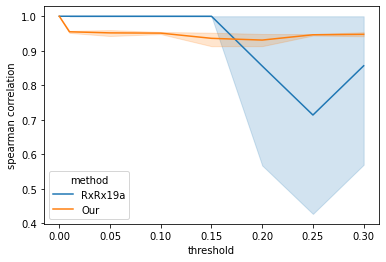

In [328]:
import seaborn as sns 
import matplotlib.pyplot as plt 
    
sns.lineplot(x="threshold", y="spearman correlation", hue='method', data=data) 
plt.show()